In [1]:
import io
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import torch.nn as nn
import torch.nn.init as init
import matplotlib.pyplot as plt

import json
from PIL import Image, ImageDraw, ImageFont
import pdb
import onnx
%matplotlib inline

In [2]:
# Super Resolution model definition in PyTorch
import torch.nn as nn
import torch.nn.init as init


class SuperResolutionNet(nn.Module):
    def __init__(self, upscale_factor, inplace=False):
        super(SuperResolutionNet, self).__init__()

        self.relu = nn.ReLU(inplace=inplace)
        self.conv1 = nn.Conv2d(1, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2, (3, 3), (1, 1), (1, 1))
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

# Create the super-resolution model by using the above model definition.
torch_model = SuperResolutionNet(upscale_factor=3)

In [3]:
# Load pretrained model weights
model_url = 'https://s3.amazonaws.com/pytorch/test_data/export/superres_epoch100-44c6958e.pth'
batch_size = 1    # just a random number

# Initialize model with the pretrained weights
map_location = lambda storage, loc: storage
if torch.cuda.is_available():
    map_location = None
torch_model.load_state_dict(model_zoo.load_url(model_url, map_location=map_location))

# set the model to inference mode
torch_model.eval()


print(torch.__version__)

x = torch.randn(1, 1, 224, 224, requires_grad=True)
torch_model.eval()

1.1.0


SuperResolutionNet(
  (relu): ReLU()
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pixel_shuffle): PixelShuffle(upscale_factor=3)
)

In [7]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("FILE_PATH_TO_ONNX_FILE")


In [43]:
from PIL import Image
from resizeimage import resizeimage
# import torchvision.transforms as transforms
import numpy as np

orig_img = Image.open("FILE_PATH_TO_IMAGE")
img = resizeimage.resize_cover(orig_img, [224,224], validate=False)
img_ycbcr = img.convert('YCbCr')
img_y_0, img_cb, img_cr = img_ycbcr.split()
img_ndarray = np.asarray(img_y_0)

img_4 = np.expand_dims(np.expand_dims(img_ndarray, axis=0), axis=0)
img_5 = img_4.astype(np.float32) / 255.0
img_5

array([[[[0.56078434, 0.5529412 , 0.53333336, ..., 0.12156863,
          0.15294118, 0.1882353 ],
         [0.6039216 , 0.58431375, 0.58431375, ..., 0.08235294,
          0.07058824, 0.08627451],
         [0.37254903, 0.42745098, 0.5176471 , ..., 0.07058824,
          0.06666667, 0.07843138],
         ...,
         [0.9098039 , 0.7137255 , 0.5764706 , ..., 0.49803922,
          0.7529412 , 0.7137255 ],
         [0.77254903, 0.79607844, 0.6784314 , ..., 0.7607843 ,
          0.7254902 , 0.65882355],
         [0.7607843 , 0.7921569 , 0.7490196 , ..., 0.84705883,
          0.827451  , 0.77254903]]]], dtype=float32)

In [39]:
ort_inputs = {ort_session.get_inputs()[0].name: img_5} 
ort_outs = ort_session.run(None, ort_inputs)
img_out_y = ort_outs[0]

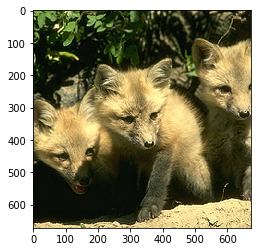

In [38]:
img_out_y = Image.fromarray(np.uint8((img_out_y[0] * 255.0).clip(0, 255)[0]), mode='L')
# get the output image follow post-processing step from PyTorch implementation
final_img = Image.merge(
    "YCbCr", [
        img_out_y,
        img_cb.resize(img_out_y.size, Image.BICUBIC),
        img_cr.resize(img_out_y.size, Image.BICUBIC),
    ]).convert("RGB")
plt.imshow(final_img)
# Save the image, we will compare this with the output image from mobile device
